In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Font modification
#plt.rcParams['font.sans-serif'] = "Times New Roman"
#plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 18


In [3]:
# Use with caution
if True:
    import warnings
    warnings.filterwarnings("ignore")

# Data loading and assembly

In [4]:
spectra = pd.read_csv('../data/cleanedset.csv')
columns = ['target', 'sampleID'] 
columns.extend([str(x) for x in range(950, 1530+1,2)])
spectra = spectra[columns]
print(spectra.shape)
spectra.head()

(591, 293)


,target,sampleID,950,952,954,956,958,960,962,964,...,1512,1514,1516,1518,1520,1522,1524,1526,1528,1530
0,94.333333,0.0,36.723839,35.745964,34.811623,33.955212,33.197552,32.570518,32.147972,31.807793,...,0.791820,0.831189,0.883438,0.940272,0.993729,1.046867,1.098642,1.152454,1.215338,1.271571
1,94.333333,0.0,36.369366,35.383987,34.443897,33.584080,32.823158,32.192280,31.770844,31.431589,...,0.685869,0.728103,0.785778,0.845810,0.902551,0.961095,1.017545,1.073209,1.138063,1.196826
2,94.333333,0.0,35.385422,34.405182,33.466976,32.614578,31.862633,31.242191,30.828016,30.496775,...,0.618997,0.659589,0.712821,0.769303,0.822148,0.875681,0.929040,0.979519,1.040625,1.100850
3,94.333333,0.0,35.121685,34.145687,33.217796,32.374218,31.630789,31.019081,30.611959,30.286642,...,0.751016,0.796110,0.852175,0.909087,0.965727,1.024710,1.080235,1.133445,1.197904,1.262516
4,76.333333,1.0,36.185947,35.209904,34.280155,33.430157,32.679989,32.062084,31.647160,31.312046,...,1.001077,1.051815,1.112780,1.175900,1.240040,1.304035,1.365576,1.426388,1.495515,1.561842


# Regression

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union

## Folds definition

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False, random_state=47)

# Splits definition

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
spectra[(spectra['target'] > 72) & (spectra['target'] < 72.5)]
spectra.drop([72,73,74,75], inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(spectra, spectra['target'], test_size=0.33, random_state=42)

## Savgol filter

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

In [10]:
from scipy.signal import savgol_filter

class Savgol(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self, window_length=5, polyorder=2, deriv=0, wavemin=950, wavemax=1530):# 
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv
        self.wavemin = wavemin
        self.wavemax = wavemax
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        colnames = [str(x) for x in range(self.wavemin, self.wavemax+1,2)]
        df = X[colnames].copy(deep=True)
        toreturn = df.apply(savgol_filter, args=(self.window_length, self.polyorder, self.deriv,1. , 0, 'nearest'), axis=1, raw=True, result_type='broadcast')
        return toreturn

params={'window_length':5, 'polyorder':2, 'deriv':1}
savgol = Savgol(**params)
savgol.fit_transform(X_train).shape

(393, 291)

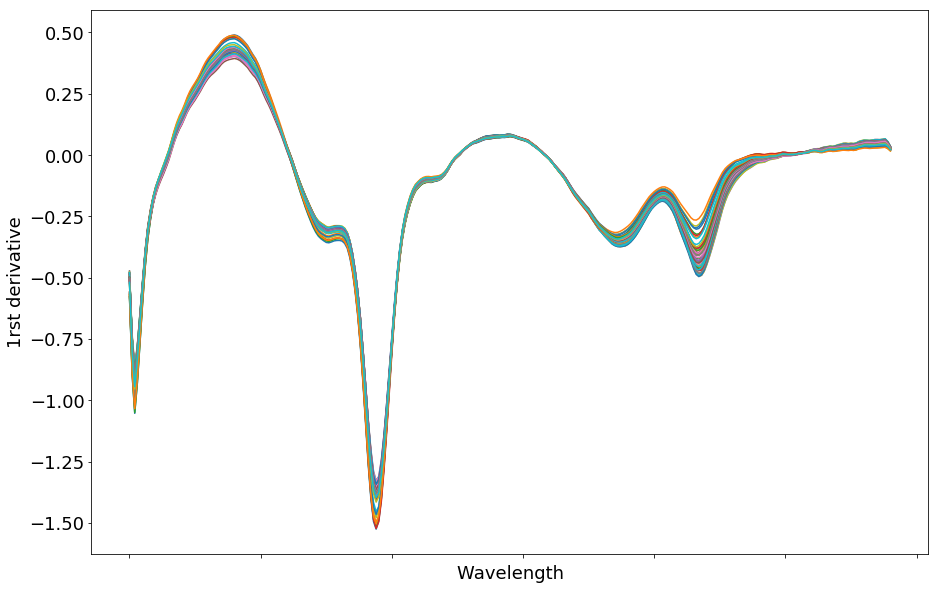

In [11]:
df = savgol.transform(spectra)
df.head(50).T.plot(legend=None, figsize=(15,10))
plt.xlabel('Wavelength')
plt.ylabel('1rst derivative')
plt.show()

## Blocs creation

In [12]:
params={'window_length':5, 'polyorder':2, 'deriv':1}
savgol = Savgol(**params)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
from sklearn.decomposition import PCA
pca = PCA()

# Tree construction

In [15]:
lrpipelist1 = [('savgol', savgol),
               ('scaler', scaler),
               ('pca', pca)] #
pipe1 = Pipeline(lrpipelist1)
#Xtrans = pipe1.fit_transform(spectra)#.shape

In [16]:
pipe1.fit_transform(X_train).shape

(393, 291)

In [17]:
from sklearn.svm import SVR
svr = SVR()

In [18]:
listpipereg = [('pipe1', pipe1), ('svr', svr)] #
pipereg = Pipeline(listpipereg)

In [19]:
pipereg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pipe1', Pipeline(memory=None,
     steps=[('savgol', Savgol(deriv=1, polyorder=2, wavemax=1530, wavemin=950, window_length=5)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

## Component Selection - SVR

In [20]:
rmsecv = []
components = [2,3,4]
components.extend(np.arange(5,50+1,5))
C_opt = []
epsilon_opt = []

for component in components:
    pipe1.set_params(pca__n_components=component)
    Xtrans = pipe1.fit_transform(X_train)
    
    svr = SVR(kernel='linear')
    C_range = np.logspace(-1, 2, 5)
    epsilon_range = np.logspace(-2, 0, 5)
    param_grid = dict(C=C_range, epsilon=epsilon_range)
    
    gridpca = GridSearchCV(svr, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='neg_mean_squared_error')
    gridpca.fit(Xtrans, y_train)
    
    C_opt.append(gridpca.best_params_['C'])
    epsilon_opt.append(gridpca.best_params_['epsilon'])
    
    svr = SVR(kernel='linear', **gridpca.best_params_)
    
    #preds = cross_val_predict(svr, Xtrans, y_train, cv=kf, n_jobs=-2)
    preds = gridpca.predict(pipe1.transform(X_test))
    score = mean_squared_error(y_test , preds)
    
    rmsecv.append(score)
    

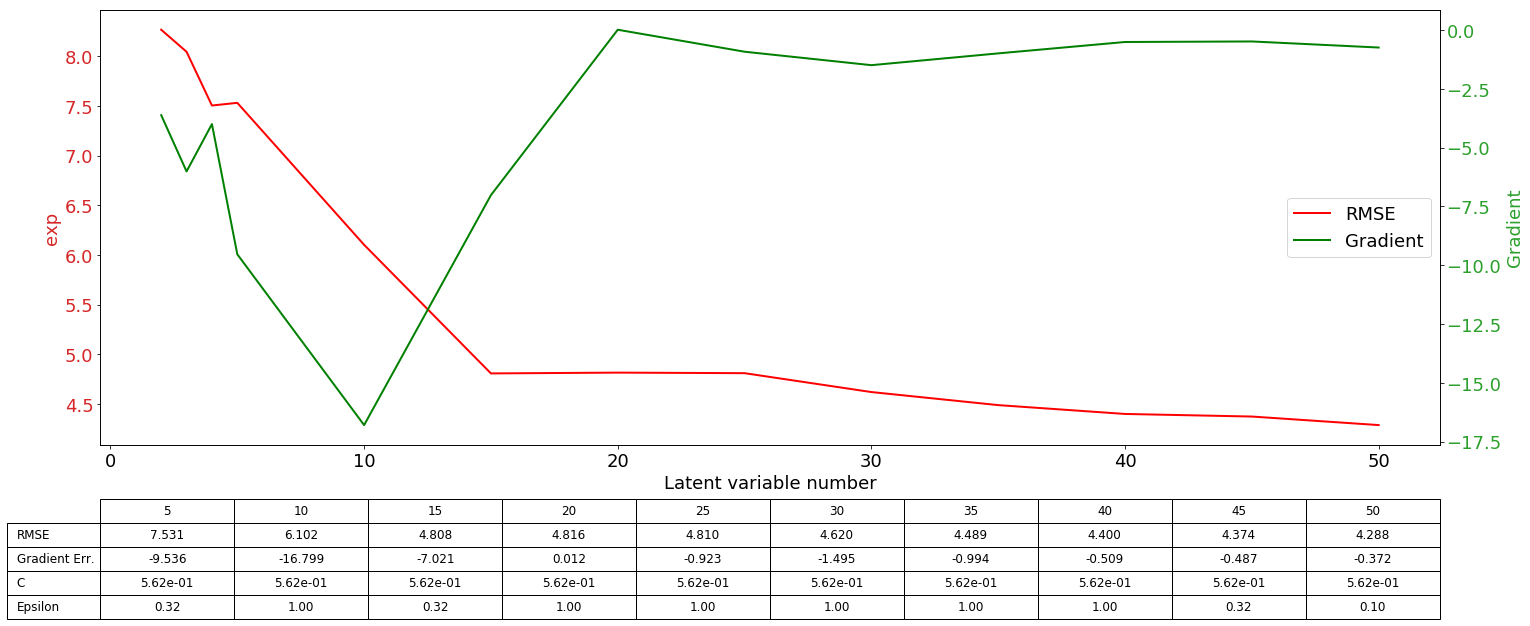

In [57]:
steps = 5

simp_C = []
simp_epsilon = []
simp_comp = []
simp_rmsecv = []
gradient = savgol_filter(rmsecv, window_length=3, polyorder=2, deriv=1, mode='nearest')
simp_gradient = []

for index, (comp, C, epsilon, rm, gr) in enumerate(zip(components, C_opt, epsilon_opt, rmsecv, gradient)):    
    if (comp)%5 == 0:
        simp_C.append('{:.2e}'.format(C))
        simp_epsilon.append('{:.2f}'.format(epsilon))
        simp_comp.append('{}'.format(int(comp)))
        simp_rmsecv.append('{:.3f}'.format(np.sqrt(rm)))
        simp_gradient.append('{:.3f}'.format(gr))

fig, ax1 = plt.subplots(figsize=(24, 8))

color = 'tab:red'
ax1.set_ylabel('exp', color=color)
ax1.tick_params(axis='y', labelcolor=color)
err=ax1.plot(components, np.array(rmsecv)**.5, '-', linewidth=2, label='RMSE', color='red')

color = 'tab:green'
ax2 = ax1.twinx()
grad=ax2.plot(components, np.gradient(rmsecv), '-', linewidth=2, label='Gradient', color='green')
ax2.set_ylabel('Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# added these three lines
lns = err+grad
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=5)

ax1.set_xlabel('Latent variable number') #,labelpad=40

the_table = plt.table(cellText=[simp_rmsecv, simp_gradient, simp_C, simp_epsilon], rowLabels=['RMSE', 'Gradient Err.', 'C', 'Epsilon'],
                      colLabels=simp_comp,
                      colLoc='center',
                      loc='bottom',
                      cellLoc='center',
                      bbox=[0, -.4, 1, 0.275])

the_table.auto_set_font_size(True)
the_table.set_fontsize(12)


plt.savefig('SVR - components - RMSECV.png', bbox_inches='tight')
plt.show()


### HyperOpt

In [22]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'savgol', 'scaler', 'pca', 'savgol__deriv', 'savgol__polyorder', 'savgol__wavemax', 'savgol__wavemin', 'savgol__window_length', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten'])

In [23]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [24]:
from sklearn.metrics import r2_score

In [25]:
counter = 0
bestscore = 1e20


def objective(params):
    global counter
    global bestscore
    counter += 1
    hyperparams = {
        'kernel': params['kernel'],
        #'degree': params['degree'],
        'C':params['C'],
        'epsilon':params['epsilon'],
        }
    
    pipe1.set_params(pca__n_components=int(params['pca__n_components']))
    pipe1.set_params(savgol__window_length=int(params['savgol__window_length'])+1)
    pipe1.set_params(savgol__deriv=int(params['savgol__deriv']))
    pipe1.set_params(savgol__wavemin=int(params['savgol__wavemin']))
    pipe1.set_params(savgol__wavemax=int(params['savgol__wavemax']))
    pipe1.set_params(savgol__polyorder=int(params['savgol__polyorder']))
    
    Xtrans = pipe1.fit_transform(X_train)
    
    svr = SVR(**hyperparams)
    
    preds = cross_val_predict(svr, Xtrans, y_train, cv=kf, n_jobs=-2)
    score = mean_squared_error(y_train , preds)
    #score = -r2_score(spectra['target'] , preds)
    
    if counter % 25 == 0:
        print("{} - RMSE {}".format(counter, score))
    if score < bestscore:
        bestscore = score
        print("{} - RMSECV {} - {}".format(counter, score, params))
    return score

space = {
    'kernel':hp.choice('kernel', ['linear', 'poly', 'rbf']), #'linear', 'poly', 'rbf'
    #'degree':hp.quniform('degree', 2, 3, 1),
    'C': hp.loguniform('C', -2, 1),
    'epsilon': hp.loguniform('epsilon', -2, 1),
    'pca__n_components': hp.quniform('pca__n_components',10, 30, 1),
    'savgol__window_length': hp.quniform('savgol__window_length', 3, 19, 2),
    'savgol__deriv':hp.quniform('savgol__deriv', 1, 2, 1),
    'savgol__wavemin': hp.quniform('savgol__wavemin', 950, 1200, 2),
    'savgol__wavemax': hp.quniform('savgol__wavemax', 1300, 1530, 2),
    'savgol__polyorder':hp.quniform('savgol__polyorder', 2, 3, 1)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500)

1 - RMSECV 36.64170833271207 - {'C': 0.48937034140714913, 'epsilon': 0.5734330743727651, 'kernel': 'linear', 'pca__n_components': 28.0, 'savgol__deriv': 2.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1460.0, 'savgol__wavemin': 1198.0, 'savgol__window_length': 4.0}
3 - RMSECV 29.637843338580435 - {'C': 0.2124747112508302, 'epsilon': 0.22953021478110508, 'kernel': 'poly', 'pca__n_components': 29.0, 'savgol__deriv': 2.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1488.0, 'savgol__wavemin': 970.0, 'savgol__window_length': 6.0}
5 - RMSECV 22.5256812930156 - {'C': 0.5251283290625468, 'epsilon': 0.7190247392637862, 'kernel': 'linear', 'pca__n_components': 26.0, 'savgol__deriv': 1.0, 'savgol__polyorder': 3.0, 'savgol__wavemax': 1368.0, 'savgol__wavemin': 1082.0, 'savgol__window_length': 6.0}
25 - RMSE 22.920062475628153
31 - RMSECV 21.758200692839672 - {'C': 1.4227671177279482, 'epsilon': 0.6761750365473829, 'kernel': 'linear', 'pca__n_components': 21.0, 'savgol__deriv': 2.0, 'savgol__pol

In [26]:
best

{'C': 0.5492351608876495,
 'epsilon': 0.5163990389269439,
 'kernel': 0,
 'pca__n_components': 30.0,
 'savgol__deriv': 2.0,
 'savgol__polyorder': 2.0,
 'savgol__wavemax': 1348.0,
 'savgol__wavemin': 1030.0,
 'savgol__window_length': 12.0}

In [27]:
pipe1.set_params(pca__n_components=int(best['pca__n_components']))
pipe1.set_params(savgol__window_length=int(best['savgol__window_length'])+1)
pipe1.set_params(savgol__deriv=int(best['savgol__deriv']))
pipe1.set_params(savgol__wavemin=int(best['savgol__wavemin']))
pipe1.set_params(savgol__wavemax=int(best['savgol__wavemax']))
pipe1.set_params(savgol__polyorder=int(best['savgol__polyorder']))
pipe1.fit(X_train)
Xtrans = pipe1.transform(X_train)

# PCA visualisation

In [28]:

Xtrans = pipe1.fit_transform(X_train)
Xtrans.shape

(393, 30)

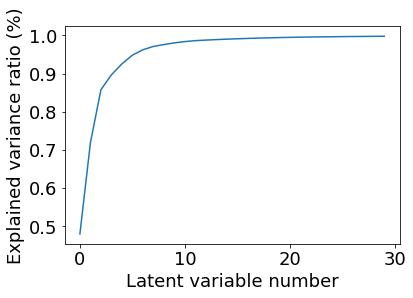

In [29]:
exp_variance_ratio_ = pipe1.named_steps['pca'].explained_variance_ratio_
cumsum=np.cumsum(exp_variance_ratio_)

plt.plot(range(cumsum.shape[0]), cumsum)

#plt.title('Cumulative sum - explained variance ratio')
plt.xlabel('Latent variable number')
plt.ylabel('Explained variance ratio (%)')
plt.savefig('SVR - pca latent variable.png', bbox_inches = 'tight')
plt.show()

In [30]:
cumsum

array([0.47980833, 0.71878517, 0.85750195, 0.89666509, 0.92537453,
       0.94811209, 0.96235228, 0.97101313, 0.97598657, 0.98037208,
       0.98377502, 0.98618386, 0.98766162, 0.98897798, 0.99014449,
       0.99111102, 0.99202032, 0.99284474, 0.99357821, 0.99425449,
       0.99483388, 0.99533665, 0.99577945, 0.99613222, 0.99646178,
       0.99678084, 0.99705415, 0.99730144, 0.99753141, 0.99775362])

## Truncated spectras

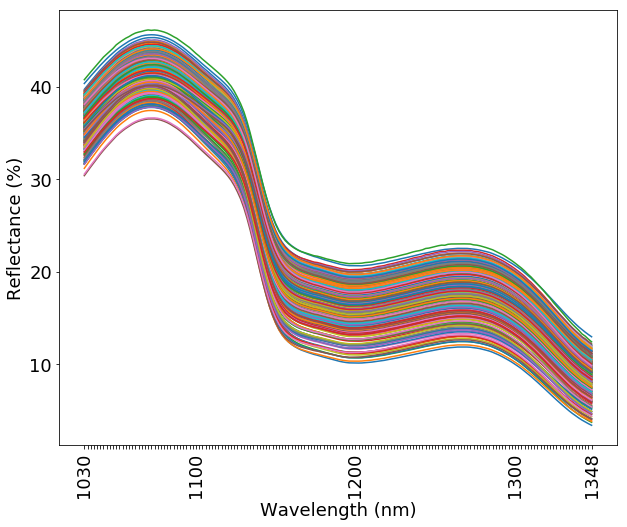

In [31]:
colnames = [str(x) for x in range(int(best['savgol__wavemin']), int(best['savgol__wavemax'])+1,2)]
df = spectra[colnames].T
df.plot(legend=False, figsize=(10,8))
#plt.title('Spectras')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.xticks(np.arange(len(colnames)), [v if (int(v) % 100 == 0) or k==0 or k==len(colnames)-1 else '' for (k,v) in enumerate(colnames)], rotation=90)
plt.savefig('SVR - Spectras - truncated.png', bbox_inches='tight')
plt.show()

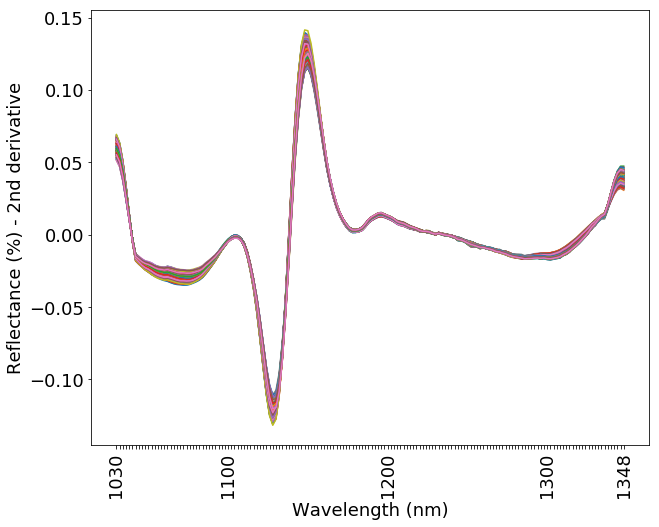

In [32]:
params={'window_length':int(best['savgol__window_length'])+1,
        'polyorder':int(best['savgol__polyorder']),
        'deriv':int(best['savgol__deriv']),
        'wavemin':int(best['savgol__wavemin']),
        'wavemax':int(best['savgol__wavemax'])}
savgol = Savgol(**params)

#colnames = [str(x) for x in range(int(best['savgol__wavemin']), int(best['savgol__wavemax'])+1,2)]
df = savgol.fit_transform(spectra).T
df.plot(legend=False, figsize=(10,8))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%) - {}nd derivative'.format(int(best['savgol__deriv'])))
plt.xticks(np.arange(len(colnames)), [v if (int(v) % 100 == 0) or k==0 or k==len(colnames)-1 else '' for (k,v) in enumerate(colnames)], rotation=90)
plt.savefig('SVR - Spectras-savgol - Elasticnet cleaning 2nd derivative.png', bbox_inches = 'tight')
plt.show()

# hyper parameters Sensitivity - RMSECV

In [33]:
C_range = np.logspace(-1, 2, 11)
epsilon_range = np.logspace(-1, 1, 11)
param_grid = dict(C=C_range, epsilon=epsilon_range)

svr = SVR(kernel='linear')

gridrmse = GridSearchCV(svr, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='neg_mean_squared_error')
gridrmse.fit(Xtrans, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=False),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'C': array([  0.1    ,   0.19953,   0.39811,   0.79433,   1.58489,   3.16228,
         6.30957,  12.58925,  25.11886,  50.11872, 100.     ]), 'epsilon': array([ 0.1    ,  0.15849,  0.25119,  0.39811,  0.63096,  1.     ,
        1.58489,  2.51189,  3.98107,  6.30957, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [34]:
gridrmse.best_params_

{'C': 3.1622776601683795, 'epsilon': 1.584893192461114}

In [35]:
(-gridrmse.best_score_)**.5

4.303648684992259

In [36]:
scores = gridrmse.cv_results_['mean_test_score'].reshape(len(C_range),len(epsilon_range))

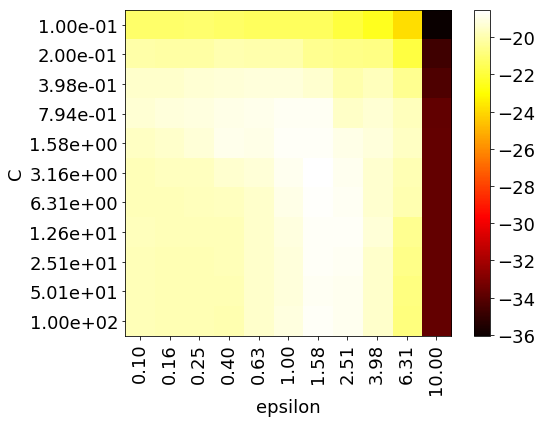

In [37]:
# heat map
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,)
plt.ylabel('C')
plt.xlabel('epsilon')
plt.colorbar()
plt.yticks(np.arange(len(C_range)), ['{:.2e}'.format(x) for x in C_range])
plt.xticks(np.arange(len(epsilon_range)), ['{:.2f}'.format(x) for x in epsilon_range], rotation=90)
#plt.title('Negative MSE score')
plt.savefig('SVR - sensitivity.png', bbox_inches='tight')
plt.show()

In [38]:
# RMSE TRAIN TEST
svr = SVR(kernel='linear', **gridrmse.best_params_)
predsrmse = cross_val_predict(svr, Xtrans, y_train, cv=kf)
(mean_squared_error(predsrmse, y_train))**.5

4.303648684992259

In [39]:
# RMSE TEST SCORE

#Fit with best parameters
Xtranstest = pipe1.transform(X_test)
svr = SVR(kernel='linear', **gridrmse.best_params_)
svr.fit(Xtrans, y_train)


# Prediction on test set
preds_test = svr.predict(Xtranstest)
(mean_squared_error(preds_test, y_test))**.5

4.838769578856597

# hyper parameters Sensitivity - R2

In [40]:
C_range = np.logspace(-1, 2, 11)
epsilon_range = np.logspace(-1, 1, 11)
param_grid = dict(C=C_range, epsilon=epsilon_range)

svr = SVR(kernel='linear')

gridr2 = GridSearchCV(svr, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='r2')
gridr2.fit(Xtrans, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=False),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'C': array([  0.1    ,   0.19953,   0.39811,   0.79433,   1.58489,   3.16228,
         6.30957,  12.58925,  25.11886,  50.11872, 100.     ]), 'epsilon': array([ 0.1    ,  0.15849,  0.25119,  0.39811,  0.63096,  1.     ,
        1.58489,  2.51189,  3.98107,  6.30957, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [41]:
gridr2.best_params_

{'C': 3.1622776601683795, 'epsilon': 1.584893192461114}

In [42]:
gridr2.best_score_

0.7506282168335766

In [43]:
scores = gridr2.cv_results_['mean_test_score'].reshape(len(C_range),len(epsilon_range))

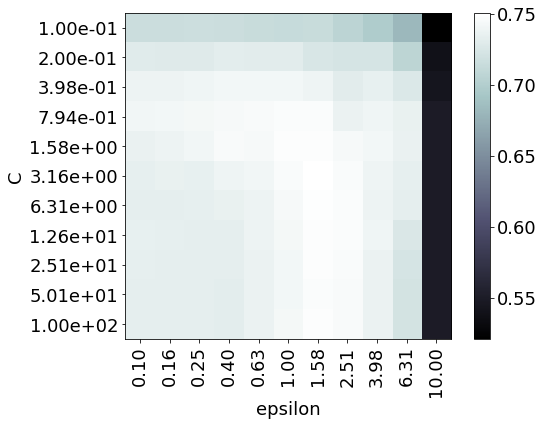

In [44]:
# heat map
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.bone,)
plt.ylabel('C')
plt.xlabel('epsilon')
plt.colorbar()
plt.yticks(np.arange(len(C_range)), ['{:.2e}'.format(x) for x in C_range])
plt.xticks(np.arange(len(epsilon_range)), ['{:.2f}'.format(x) for x in epsilon_range], rotation=90)
plt.savefig('SVR - sensitivity R2.png', bbox_inches='tight')
plt.show()

In [45]:
# R2 CV train set
svr = SVR(kernel='linear', **gridr2.best_params_)
predsr2 = cross_val_predict(svr, Xtrans, y_train, cv=kf)
r2_score(predsr2, y_train)

0.7097330367823396

In [46]:
# R2 CV test set

svr = SVR(kernel='linear', **gridr2.best_params_)
#Fit with best parameters

Xtranstest = pipe1.transform(X_test)
svr.fit(Xtrans, y_train)

predsr2 = svr.predict(Xtranstest)
r2_score(y_test,predsr2)

0.6833945408864881

## Score accuracy - SVR

In [47]:
# Generate test results

svr = SVR(kernel='linear', **gridrmse.best_params_)

#Fit with best parameters
Xtrans = pipe1.fit_transform(X_train)
svr.fit(Xtrans, y_train)


# Prediction on test set
Xtranstest = pipe1.transform(X_test)
preds_test = svr.predict(Xtranstest)
(mean_squared_error(preds_test, y_test))**.5

4.838769578856597

In [48]:
df = pd.DataFrame({'target':y_test, 'pred':preds_test}) #
df.head()

,target,pred
524,90.333333,88.486379
288,84.000000,80.794233
516,92.000000,92.459387
335,92.000000,91.138567
214,91.000000,92.446174


In [49]:
if False:
    df.drop([72, 73,75], inplace=True)

In [50]:
df['delta'] = df['target'] - df['pred']
df['deltaabs'] = np.abs(df['delta'])
df.head()

,target,pred,delta,deltaabs
524,90.333333,88.486379,1.846954,1.846954
288,84.000000,80.794233,3.205767,3.205767
516,92.000000,92.459387,-0.459387,0.459387
335,92.000000,91.138567,0.861433,0.861433
214,91.000000,92.446174,-1.446174,1.446174


In [51]:
samplesize = df.shape[0]
print('sample size:', samplesize)

for errorabs in [1 ,2 ,3 ,4 ,6 ,8, 10]:
    correctcount = df[df['deltaabs'] < errorabs].shape[0]
    percent = correctcount/samplesize
    print('prediction +/- {:.1f} : percent {:05.02f} %'.format(errorabs, percent*100))

sample size: 194
prediction +/- 1.0 : percent 19.59 %
prediction +/- 2.0 : percent 32.47 %
prediction +/- 3.0 : percent 50.00 %
prediction +/- 4.0 : percent 63.40 %
prediction +/- 6.0 : percent 81.96 %
prediction +/- 8.0 : percent 89.69 %
prediction +/- 10.0 : percent 95.36 %


/Users/cricket/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


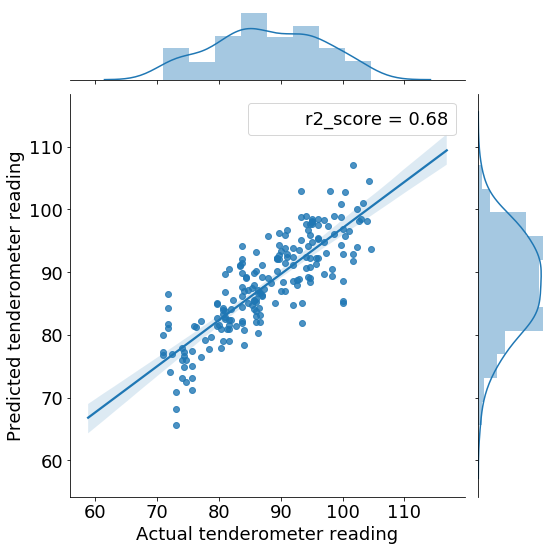

In [52]:
import seaborn as sns
from sklearn.metrics import r2_score

sns.jointplot(x='target', y='pred', data=df,  height=8, stat_func=r2_score, kind='reg',)
plt.xlabel('Actual tenderometer reading')
plt.ylabel('Predicted tenderometer reading')
plt.savefig('SVR - result regression SVR.png', bbox_inches='tight')
plt.show()




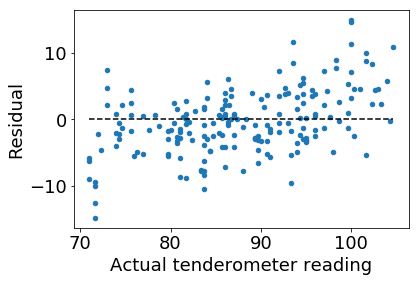

,delta
count,194.000000
mean,-0.288375
std,4.842666
min,-14.802016
25%,-3.099866
50%,-0.546421
75%,2.615398
max,14.923013


In [53]:
df.plot.scatter('target', 'delta')
plt.plot([df['target'].min(), df['target'].max()], [0, 0], color='k', linestyle='--')
plt.xlabel('Actual tenderometer reading')
plt.ylabel('Residual')
plt.savefig('SVR - residual.png', bbox_inches='tight')
plt.show()
df[['delta']].describe()



## Result saving

In [54]:
params = best
params = {**params, **gridr2.best_params_}
params = {**params, 'RMSE train':mean_squared_error(y_train, predsrmse)**.5, 'R2 train':r2_score(y_train, predsrmse)}
params = {**params, 'RMSE test':mean_squared_error(y_test, preds_test)**.5, 'R2 test':r2_score(y_test, preds_test)}
params

{'C': 3.1622776601683795,
 'epsilon': 1.584893192461114,
 'kernel': 0,
 'pca__n_components': 30.0,
 'savgol__deriv': 2.0,
 'savgol__polyorder': 2.0,
 'savgol__wavemax': 1348.0,
 'savgol__wavemin': 1030.0,
 'savgol__window_length': 12.0,
 'RMSE train': 4.303648684992259,
 'R2 train': 0.7586833508135405,
 'RMSE test': 4.838769578856597,
 'R2 test': 0.6833945408864881}

In [55]:
samplesize = df.shape[0]
print('sample size:', samplesize)

for errorabs in [1 ,2 ,3 ,4 ,6 ,8, 10]:
    correctcount = df[df['deltaabs'] < errorabs].shape[0]
    percent = correctcount/samplesize
    print('prediction +/- {:.1f} : percent {:05.02f} %'.format(errorabs, percent*100))
    params = {**params, 'preds +/-{}'.format(int(errorabs)):percent}


sample size: 194
prediction +/- 1.0 : percent 19.59 %
prediction +/- 2.0 : percent 32.47 %
prediction +/- 3.0 : percent 50.00 %
prediction +/- 4.0 : percent 63.40 %
prediction +/- 6.0 : percent 81.96 %
prediction +/- 8.0 : percent 89.69 %
prediction +/- 10.0 : percent 95.36 %


In [56]:
resultset = pd.DataFrame(params, index=['SVM'])
resultset.to_csv('../data/res_svm.csv')
resultset.T

,SVM
C,3.162278
epsilon,1.584893
kernel,0.000000
pca__n_components,30.000000
savgol__deriv,2.000000
savgol__polyorder,2.000000
savgol__wavemax,1348.000000
savgol__wavemin,1030.000000
savgol__window_length,12.000000
RMSE train,4.303649
